#  A/B Test Project

## Task statement

You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

## Goal
- Test whether the new recommendation system was able to increase conversion rates by at 10% per each stage in the funnel 


## Tech description
Date: **2020-12-07 - 2021-01-01** (date stopped taking in new users -> **2020-12-21**)

**Purpose** of the test: testing changes related to the introduction of an improved recommendation system

Expected **result**: within 14 days of signing up, users will show better conversion into product page views (the product_page event), product card views (product_card) and purchases (purchase). At each of the stage of the funnel:

- product_page → product_card → purchase, there will be at least a 10% increase.
 -> compared to first day
 -> per user make two columns (first and 14 days after conversion rates)
 (may need to drop some users)

**Metrics**: 
 - *Product page view* # of product page views / total view 
 - *Product card view* # of product_card views/ total view
 - *Purchases*: bought / did not buy (or bought / unique visits)
 
**Audience**: 15% of the new users from the EU region

Expected number of test **participants**: 6000

## Findings
- Unique user conversion **did not** statistically differ for events in the **product page and product cart** page.
- For the **purchase page**, users in the **control group converted 2.36% better** than the experimental group and this difference was found to be statistically significant **(p < .03)**.
    - In terms of the result, this may have been that there are more users that were concentrated in the purchase stage (from funnel findings) which warrants further testing. 
- It seems likely that users in **group A were disproportionately shared direct links to the purchase page** more often than users in group B, hence the difference in # of purchase. A further follow up analysis can be done to assess effectiveness of the purchase page redirect link. 

-----------------------------------------------------------------

## Data Source
Structure of `ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020:

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

Structure of `final_ab_new_users_upd.csv`  — all users who signed up in the online store from December 7 to 21, 2020:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

Structure of `final_ab_events_upd.csv` — all events of the new users within the period from December 7, 2020 to January 1, 2021:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

Structure of `final_ab_participants_upd.csv` — table containing test participants:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to


# Libraries Used

In [57]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st
import statsmodels.api as sm
from scipy.stats import shapiro
from math import log, floor, sqrt, log10
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import ticker

from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)

from IPython.display import display, HTML

# Common Functions
(modifying chart and null & erroneous value check)

In [2]:
def modifyChart(ax,title,labelSize,xLabel='',yLabel='',
                titleSize=False,maxs=False,grid=False,
                highlightTop =False,highlightXVal =False, topValueColor=False):
    """
    Function that takes in graph variables for the purpose of customizing 
    their default settings (ie. setting label size)
    """
    if titleSize != False:
        ax.set_title(title,fontsize=titleSize,fontweight='semibold', pad=10)
    else:
        ax.set_title(title)

    # spines
    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('lightgrey')

    # labels
    ax.set_ylabel(yLabel, labelpad=5, fontsize=16)
    ax.set_xlabel(xLabel, labelpad=5, fontsize=16)

    # tick settings
    ax.tick_params(labelsize=labelSize)
    ax.tick_params(axis='both', left=False, bottom=False)
    #custom settings 
    if grid:
        ax.grid(axis=grid, alpha=.4)
    if maxs:
        modifyMaxYTick(ax,maxs,highlightTop)
    if topValueColor:
        modifyMaxValueColor(ax,topValueColor)
    if highlightTop:
        ax.get_yticklabels()[-1].set_color('black')
    if highlightXVal:
        # get first x ticklabel and set color to black
        ax.get_xticklabels()[0].set_color('black')

In [3]:
def modifyMaxYTick(ax, maxValue,highlightTop):
    # keep all except last  tick - ensure that the ticks don't overlap
    midCenterQuarter = (ax.get_yticks()[1] - ax.get_yticks()[0]) / 4

    ax.set_ylim(0, maxValue)  # set the yticks
    # add the last tick value
    y_ticks = np.append(
        [i for i in ax.get_yticks() if i < (maxValue - midCenterQuarter)], [maxValue])
    # set the modified y ticks
    ax.set_yticks(y_ticks)

In [4]:
def modifyMaxValueColor(ax,topValueColor):
    ax.get_children()[0].set_color(topValueColor)
    ax.get_children()[-1].set_alpha(.8)
# changing size and color of tick labels (ticks are set to 0 to not display)
    ax.tick_params(labelsize=15, size=0, labelcolor='#8a8a8d')

In [5]:
def missing_values(data):
    """
    Function that takes in a dataframe, iterates over each of its columns and checks for
    common indicators of missing values (ie. negative values).   

    Args:
         data (pandas.DataFrame): Dataframe to be checked

    Returns:
        list (dict): a list containing (if any) a dictionar[y/ies] of key:value pair in the 
        following format - {column's missing value: % of column's missing value} - sorted in descending order
    """
    faultyData = {}
    if len(data.columns) <= 0:
        print('Something went wrong. No columns detected.')
    lenData = len(data)

    # iterate through all columns in dataset to search for each defined missing value
    for col in data.columns:
        if data[col].isnull().any():
            percentMissing = data[col].isnull().sum() / lenData
            # null
            faultyData[col] = f"Null values in {col}: {round(percentMissing*100,2)}"

        try:
            if len(np.where(data[col] == '')) > 1:
                percentMissing = len(data[data[col] == '']) / lenData
                # empty string
                faultyData[col] = f"Empty string values in {col}: {round(percentMissing*100,2)}"
        except:
            print(col)

        # if value is a number and less than 0
        if np.issubdtype(data[col].dtype, np.number) and len(data[data[col] < 0]) > 1:
            percentMissing = len(data[data[col] < 0]) / lenData
            # negative value
            faultyData[col] = f"Negative values in {col}: {round(percentMissing*100,2)}"

        commonFaultyValues = ['n/a', 'na', 'an', 'n\a', '?', 'none', 'null']
        try:
            if len(data[data[col].str.lower.isin(commonFaultyValues)]) > 1:
                percentMissing = len(
                    data[data[i].str.lower.isin(commonFaultyValues)]) / lenData
                # other
                faultyData[col] = f"Other null values present in {col}: {round(percentMissing*100,2)}"
        except:
            print(col)

    return sorted(faultyData.items(),
                  key=lambda x: float(faultyData[x[0]].split(' ')[-1]),
                  reverse=True)

# General Overview

I wasn't able to access the dataset through notion or the current virtual machine. As a loop around this, I uploaded my files to github.

In [6]:
url1='https://raw.githubusercontent.com/dannygarcia193/datasets/master/ab_project_marketing_events.csv'
url2='https://raw.githubusercontent.com/dannygarcia193/datasets/master/final_ab_events_upd.csv'
url3='https://raw.githubusercontent.com/dannygarcia193/datasets/master/final_ab_new_users_upd.csv'
url4='https://raw.githubusercontent.com/dannygarcia193/datasets/master/final_ab_participants_upd.csv'


In [7]:
marketingEventsCalendar = pd.read_csv(url1)
newUsersEvents = pd.read_csv(url2)
newUsers = pd.read_csv(url3)
testParticipants = pd.read_csv(url4)

In [8]:
display(HTML(newUsers.sample(5).to_html()),
        HTML(newUsersEvents.sample(5).to_html()),
        HTML(testParticipants.sample(5).to_html()),
        HTML(marketingEventsCalendar.sample(5).to_html()))

,user_id,first_date,region,device
40923,BE52857ABCAD4C9B,2020-12-18,EU,PC
51692,5997E64AB7377789,2020-12-13,EU,Android
45613,6020290DC9E4D2E5,2020-12-12,APAC,PC
27346,3D2555DA73477B20,2020-12-09,N.America,Mac
45203,ECDD5929880E17CC,2020-12-12,CIS,PC


,user_id,event_dt,event_name,details
293569,4D8AB9EBFDA970EB,2020-12-14 00:06:42,login,NaN
271047,1CDA74BC1E01F34C,2020-12-12 02:47:40,login,NaN
110707,2B8FD20CA8A2A616,2020-12-23 04:27:17,product_cart,NaN
221006,F4E72AA8FD569C94,2020-12-23 21:46:59,product_page,NaN
245588,0A23834B25FA746E,2020-12-07 16:04:45,login,NaN


,user_id,group,ab_test
7872,4605FBBDF5385EB4,A,interface_eu_test
607,E1E0F9C8926A96B4,A,recommender_system_test
2467,505D67B4B604CF79,A,recommender_system_test
1581,3AAD38BCD2DEEF82,A,recommender_system_test
11218,C86EB1E0995A33A9,B,interface_eu_test


,name,regions,start_dt,finish_dt
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


No need for marketing events in this task. Values in the detail columns will be checked.

In [9]:
display(HTML(newUsers.info()),print(),
        HTML(newUsersEvents.info()),print(),
        HTML(testParticipants.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id 

<IPython.core.display.HTML object>

None

<IPython.core.display.HTML object>

None

<IPython.core.display.HTML object>

Missing column in the events dataframe as well date columns in need of type conversion (to pandas datetime object).

In [10]:
newUsers

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [11]:
newUsers['first_date'] = pd.to_datetime(newUsers['first_date'])
newUsersEvents['event_dt'] = pd.to_datetime(newUsersEvents['event_dt'])

Checking for missing values.

In [12]:
for df in [newUsers, newUsersEvents, testParticipants]:
    print(missing_values(df))

user_id
first_date
region
device
[]
user_id
event_dt
event_name
details
[('details', 'Null values in details: 85.77')]
user_id
group
ab_test
[]


C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Details columns contains a large portion of missing values. Let's check the column out.

In [13]:
newUsersEvents['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Details column contains what looks like to be price of purchase of which prices range in the low tier (<\\$10) to a high tier (> \\$99). We can also infer visitors from customers using this column but for the purpose of this task, won't be needed. We'll take a quick look in the EDA stage nonetheless.

Checking for duplicates

In [14]:
for df in [newUsers, newUsersEvents, testParticipants]:
    print(df.duplicated().sum())

0
0
0


No duplicates.

# Data Preprocessing (and validation)

**Note:** Went through and confirmed that the value names of the tests got mixed up. The test of interest for this A/B analyses is recommender system test but in this dataframe it's labeled as the EU interface test.

In [15]:
#retrieve and split users that fall within the rec. and interface test 
rec = testParticipants.query("ab_test =='recommender_system_test'")
interface=testParticipants.query("ab_test == 'interface_eu_test'")

assert(newUsers['user_id'].nunique()==len(newUsers)), 'Users in DF are not unique!'

# inner join on unique users (see assertion above); then get the share of users per A/B group
display('Recommender  System Test',
pd.merge(newUsers,rec, on='user_id',how='inner')['group'].value_counts(normalize=True)),print('EU Interface Test'),
pd.merge(newUsers,interface, on='user_id',how='inner')['group'].value_counts(normalize=True)

'Recommender  System Test'

A    0.747483
B    0.252517
Name: group, dtype: float64

EU Interface Test


A    0.503871
B    0.496129
Name: group, dtype: float64

Based on the recommender system test's abnormal share of users per AB test it could have been that the predecessor chose an unequal sample size or that the test names got mixed up. I erred with the latter after a confirmation.

In [16]:
recommenderSystemTest = testParticipants.query("ab_test =='interface_eu_test'"
                                              ).reset_index(drop=True)

Retrieving users who are in the test of interest; those in the other test are excluded.

In [17]:
recommenderTestUsers = recommenderSystemTest['user_id'].unique()
previousLen = len(newUsers)
newUsers = newUsers.query("user_id in @recommenderTestUsers").reset_index(drop=True)
print(previousLen,len(newUsers)/previousLen)

58703 0.18482871403505782


Dropped a large portion of users; kept 20%. Fine since now we have the users and test of interest.

Checking if correctly placed in one variation only.

In [18]:
def checkIfOneGroup(x):
    assert(x==1),'Does not belong to just one group'
    return x


In [19]:
(recommenderSystemTest
.groupby('user_id') #unique users
.agg({"group":'nunique'})['group'] #unique group (max =2 -> A and B)
.apply(lambda x:checkIfOneGroup(x)) 
.unique())

array([1], dtype=int64)

Correctly placed in one group

Confirming that: "15% of the new users from the EU region"

In [20]:
#just to be sure
assert(newUsers['user_id'].nunique() == len(newUsers)), 'Should have been the same length per data description'

#only dataset with region values
newUsers['region'].value_counts(normalize=True)*100

EU    100.0
Name: region, dtype: float64

Keeping users from the recommender systems test.

In [21]:
previousLen = len(newUsersEvents)
newUsersEvents=  newUsersEvents.query("user_id in @recommenderTestUsers")
len(newUsersEvents) / previousLen, previousLen, len(newUsersEvents) 

(0.18625829182015335, 423761, 78929)

18% kept from users as well but fine in this case.

Checking that dates fit technical description. 

    Date: 2020-12-07 - 2021-01-01 (date stopped taking in new users -> 2020-12-21)

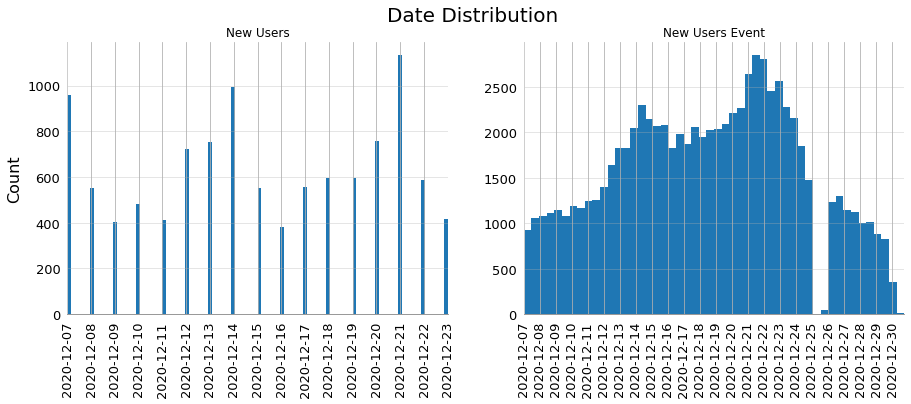

In [22]:
fig, ax = plt.subplots(ncols=2)
newUsers['first_date'].hist(figsize=(15, 5), bins=100, ax=ax[0])
newUsersEvents['event_dt'].hist(figsize=(15, 5), bins=50, ax=ax[1])

#adjusting date range (min to max) for x axis
[ax[i].set_xlim(date.min(), date.max()) 
 for i, date in zip(
     [0, 1], [newUsers['first_date'], newUsersEvents['event_dt']])]

# applying that change to the x ticks
[ax[i].set_xticks(pd.date_range(date.min(), date.max())) 
 for i, date
 in zip([0, 1], [newUsers['first_date'], newUsersEvents['event_dt']])]

[modifyChart(ax[i], 'New Users Event' if i ==
             1 else 'New Users', 13, grid='y') for i in [0, 1]]
[ax[i].tick_params(axis='x', labelrotation=90) for i in [0, 1]]

plt.suptitle('Date Distribution', fontsize=20)
ax[0].set_ylabel('Count')
plt.show()

The maximum date that new users should have been recruited is the 21st. New users in the 22nd and 23rd dates will be dropped. In addition another potential comes up: the maximum date of events recorded is the 30th which does fit the end date in the description but per the description: 
    - "Expected result: within 14 days of signing up, users will show better conversion"
        - Thus if we consider the last date recorded (21st) than confirming this result for all given new  users will not be possible. Testing the results as is will though so that'll be the road taken.

In [23]:
len(newUsers[newUsers["first_date"] >"2020-12-21"])/ len(newUsers) *100

9.235023041474655

9% of unique users will be dropped. 

In [24]:
#first date occurring before the 22nd 
newUsers = newUsers[newUsers["first_date"] <"2020-12-22"].sort_values('first_date')

newUsers.head()

,user_id,first_date,region,device
0,2E1BF1D4C37EA01F,2020-12-07,EU,PC
631,C794BC89AD7DB99D,2020-12-07,EU,iPhone
632,6C397804C342D071,2020-12-07,EU,Android
633,25FB6D588B332057,2020-12-07,EU,Android
634,012EE9FDC4BCCC06,2020-12-07,EU,PC


Updating. Keeping users w/ first date before the Dec. 22nd.

In [25]:
usersToKeep = newUsers['user_id']

previousLen = len(newUsersEvents)
newUsersEvents=  newUsersEvents.query("user_id in @usersToKeep")
print(len(newUsersEvents) / previousLen, len(newUsersEvents))

previousLen = len(recommenderSystemTest)
recommenderSystemTest=  recommenderSystemTest.query("user_id in @usersToKeep")
print(len(recommenderSystemTest) / previousLen, len(recommenderSystemTest)/2)
recommenderSystemTest['group'].value_counts(normalize=True)*100

0.9302411027632429 73423
0.9076497695852535 4924.0


A    50.548335
B    49.451665
Name: group, dtype: float64

Share of users per group is roughly equal. 

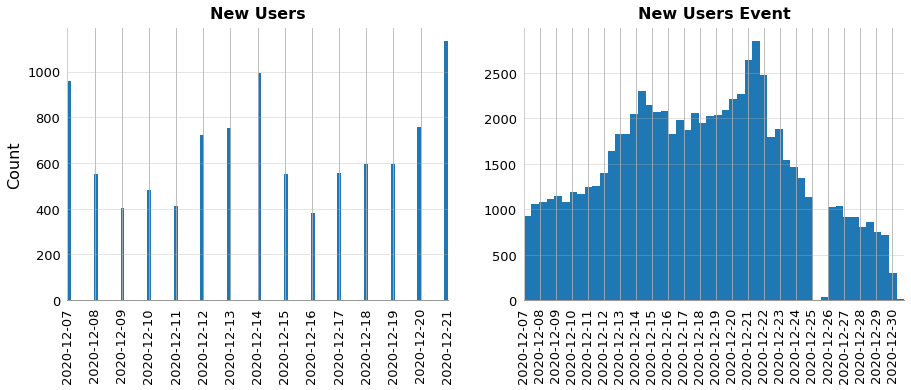

In [26]:
fig, ax = plt.subplots(ncols=2)
newUsers['first_date'].hist(figsize=(15, 5), bins=100, ax=ax[0])
newUsersEvents['event_dt'].hist(figsize=(15, 5), bins=50, ax=ax[1])

[ax[i].set_xlim(date.min(), date.max()) for i, date
 in zip([0, 1], [newUsers['first_date'], newUsersEvents['event_dt']])]
[ax[i].set_xticks(pd.date_range(date.min(), date.max())) for i, date
 in zip([0, 1], [newUsers['first_date'], newUsersEvents['event_dt']])]
[modifyChart(ax[i], 'New Users Event' if i == 1 else 'New Users',
             13, grid='y', titleSize=16) for i in [0, 1]]
[ax[i].tick_params(axis='x', labelrotation=90) for i in [0, 1]]
ax[0].set_ylabel('Count')
plt.show()

Much better.
- If we take into account that most participants weren't recruited up until the 21st, than this may have distorted the activity seen in the second chart. 
- Nonetheless, the pattern remains of user activity whining down close to the Christmas and continuing that pattern thereafter.

Did users visit the online store on the 25th?

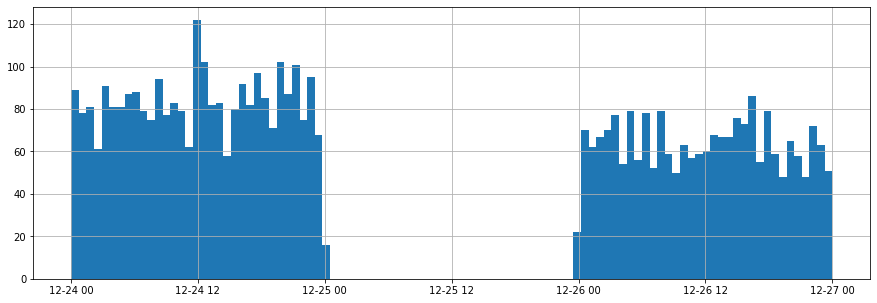

In [27]:
newUsersEvents[(newUsersEvents['event_dt']> "2020-12-24")
               & (newUsersEvents['event_dt']< "2020-12-27")]['event_dt'].hist(figsize=(15,5),bins=100)

We can say that no users visited the store on the 25th given the activity above.

In [28]:
newUsersEvents[(newUsersEvents['event_dt']> "2020-12-24 23:54:12")
               & (newUsersEvents['event_dt']< "2020-12-26")]

,user_id,event_dt,event_name,details
52613,8996B3FC799D5250,2020-12-24 23:54:46,purchase,9.99
225634,8996B3FC799D5250,2020-12-24 23:54:46,product_page,NaN
400119,8996B3FC799D5250,2020-12-24 23:54:46,login,NaN


# Exploratory Data Analysis

Exploring unique users per event and event proportion.

In [29]:
#getting data ready
usersPerEvent = (newUsersEvents
             .groupby(['event_name'])
             .agg({"user_id": "nunique"})
             .sort_values('user_id', ascending=False))

eventProp = (newUsersEvents['event_name']
              .value_counts()
              .sort_values(ascending=False))

dataframes = [usersPerEvent, usersPerEvent, eventProp, eventProp]

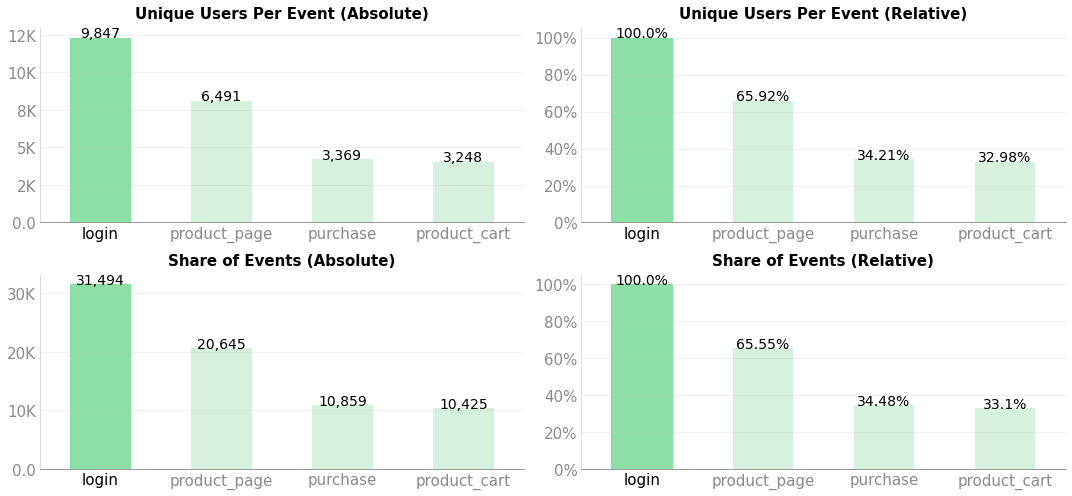

In [97]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2, nrows=2)
axes = [(row, col) for row in range(0, 2) for col in range(0, 2)]

for DF, i in zip(dataframes, axes):
    name = ' (Absolute)' if i[1] == 0 else ' (Relative)'
    if i[1] == 0: #ABSOLUTE graph
        chart = DF.plot(kind='bar', rot=0, alpha=.9,
                        ax=ax[i], legend=False, color='#d3f0dc')
    #--------------------------------------------------------------------------------
    if i[1] == 1: #RELATIVE graph
        chart = round(DF.divide(DF.max())*100, 2)
        chart.plot(kind='bar', rot=0, alpha=.9,
                   ax=ax[i], legend=False, color='#d3f0dc')
    ax[i].yaxis.set_major_formatter(
        ticker.PercentFormatter()) if i[1] == 1 else ''
    #------------------------------------------------------------------------------
    #labeling chart
    percent = '' if i[1] == 0 else '%'
    labels = DF.values if i[1] == 0 else chart.values
    for event, prop in zip(ax[i].get_xticks(), labels):
        plt.sca(ax[i])
        plt.text(event, prop, f'{prop[0]:,}'+percent if i[0] == 0 else f'{prop:,}'+percent,
                 fontsize=14, horizontalalignment='center')
    #additional modifications
    modifyChart(ax[i], 'Share of Events'+name if i[0] == 1 else 'Unique Users Per Event'+name, 13, titleSize=15,
                topValueColor='#80DE9F',highlightXVal=True)
    if i[1] == 0:
        ax[i].set_yticklabels([f'{human_format(i,precision=0)}' for i in ax[i].get_yticks()])
    ax[i].grid(axis='y',alpha=.2)
plt.tight_layout()

In [31]:
newUsersEvents[newUsersEvents['event_name'] == 'product_cart']

,user_id,event_dt,event_name,details
60314,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
60315,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
60319,E6AF85675078215D,2020-12-07 16:23:47,product_cart,NaN
60336,3E90A4CA2F922CE4,2020-12-07 12:30:14,product_cart,NaN
60342,05AAB890585C38F7,2020-12-07 03:46:48,product_cart,NaN
...,...,...,...,...
120400,317765BEF86DA9AE,2020-12-29 04:49:27,product_cart,NaN
120409,BCEC881B3C573B2B,2020-12-29 08:17:20,product_cart,NaN
120421,4584E51B99DE51AE,2020-12-30 07:39:32,product_cart,NaN
120430,6181F3835EBE66BF,2020-12-30 12:00:00,product_cart,NaN


Here we can see that users don't follow the pattern defined by the expected result: **"At each of the stage of the funnel product_page → product_card → purchase ..."**

- Purchase events recorded per unique users as well as in the event proportion, have the purchase page being more active than the product card one. 
- This more likely than not could have been due to a direct link sending users straight to the purchase page and thus skipping the product cart page. 
    - However, this my have not been a good practice as it biased the proposed(see quote above) natural behavior of users. 

Merging the three dataframes into one.

In [32]:
users = pd.merge(newUsers, newUsersEvents, on ='user_id').merge(recommenderSystemTest,on='user_id').fillna(0)

In [33]:
print(len(newUsersEvents))
users

73423


,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-07 09:05:47,product_cart,0.0,A,interface_eu_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-10 04:13:53,product_cart,0.0,A,interface_eu_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-12 17:54:57,product_cart,0.0,A,interface_eu_test
3,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-07 09:05:46,product_page,0.0,A,interface_eu_test
4,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-10 04:13:53,product_page,0.0,A,interface_eu_test
...,...,...,...,...,...,...,...,...,...
73418,AA49424D3F80982D,2020-12-21,EU,Android,2020-12-22 11:51:27,product_page,0.0,A,interface_eu_test
73419,AA49424D3F80982D,2020-12-21,EU,Android,2020-12-24 12:59:13,product_page,0.0,A,interface_eu_test
73420,AA49424D3F80982D,2020-12-21,EU,Android,2020-12-21 00:42:39,login,0.0,A,interface_eu_test
73421,AA49424D3F80982D,2020-12-21,EU,Android,2020-12-22 11:51:27,login,0.0,A,interface_eu_test


Exploring daily distribution of events per unique user

In [34]:
users['day'] = users['event_dt'].dt.date
users['hour'] = users['event_dt'].dt.hour

In [35]:
#group by users and obtain their total event count (here event_name is a dummy variable)
eventUserCount = (users.groupby('user_id')
                .agg({'event_name':'count'})['event_name'])

In [36]:
users['event_dt'].max() - users['event_dt'].min()

Timedelta('23 days 18:26:07')

Event distributions will be in the context of 23 days.

Text(0.5, 0, 'Event Count')

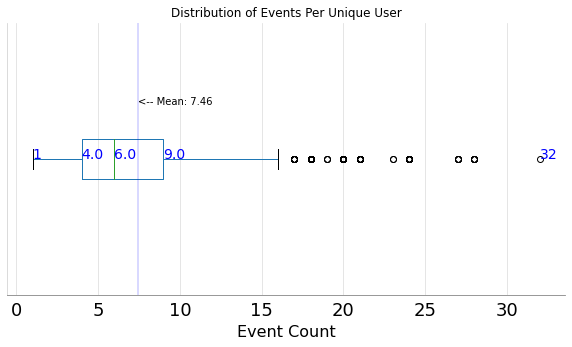

In [37]:
ax=eventUserCount.sort_values().plot.box(figsize=(10, 5), vert=False)
func = ['median','min','max',lambda x: x.quantile(.25),lambda x:x.quantile(.75)]

[plt.text(eventUserCount.agg(func),1,eventUserCount.agg(func),fontsize=14,color='blue') for func in func]
plt.text(eventUserCount.mean(),1.2,f'<-- Mean: {round(eventUserCount.mean(),2)}')

plt.axvline(eventUserCount.mean(),color='blue',alpha=.2)
ax.set_yticklabels([])
modifyChart(ax, 'Distribution of Events Per Unique User',18,grid='x')
plt.xlabel('Event Count')

- Half of the users had between 4 to 9 events with very few having over 15 events recorded in their log. This may have been due to the recruitment date but regardless seems like users aren't as active on the platform.

Checking for hour activity. 

In [38]:
def turnIntoAMPM(x):
    if x>11:
        if x==12: return '12 PM'
        return "{} PM".format(x - 12)
    else:
        if x==0: return '12 AM'
        return "{} AM".format(x)

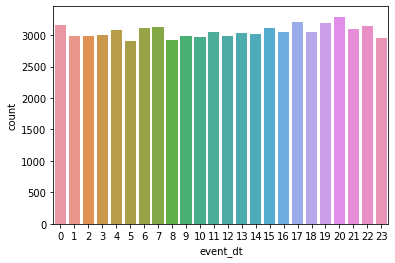

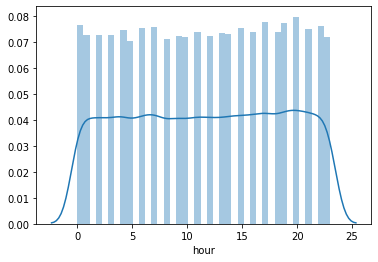

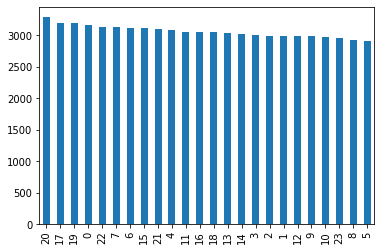

In [39]:
sns.countplot(users['event_dt'].dt.hour)
plt.show()
sns.distplot(users['hour'])
plt.show()
users['hour'].value_counts().plot.bar()

The hour distribution doesn't make sense given that users are stated to be in the EU region. 

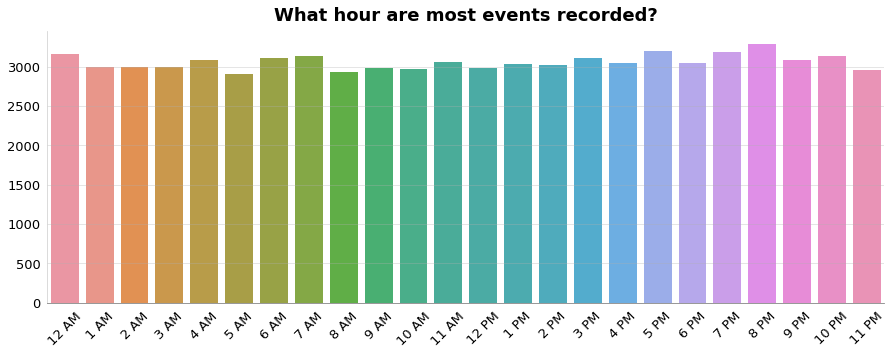

In [40]:
fig,ax= plt.subplots(figsize=(15,5))
sns.countplot(users['hour'].sort_values().apply(turnIntoAMPM))
ax.tick_params(axis='x',labelrotation=45)
modifyChart(ax, "What hour are most events recorded?", 13, grid='y',titleSize=18)
plt.show()

- Interestingly their is no clear hour in which the most events are recorded in. 
- The hours in the distribution seem odd especially considering that the per the calculation above all users are from the EU region.
    - Maybe in this case, the region also got wrongly recorded (if we are to consider that EU interface test label was switched with recommender system test label). So maybe the users are from other regions of which may explain the distribution. This will definitely need to be confirmed though with the person in charge of the dataset.

Checking if users only visited the day site for one day.

In [58]:
def human_format(num, precision=2, suffixes=['', 'K', 'M', 'G', 'T', 'P']):
    if num <1: return num #avoid dividing by 0 or negatives
    m = int(log10(num) // 3)
    return f'{num/1000.0**m:.{precision}f}{suffixes[m]}'

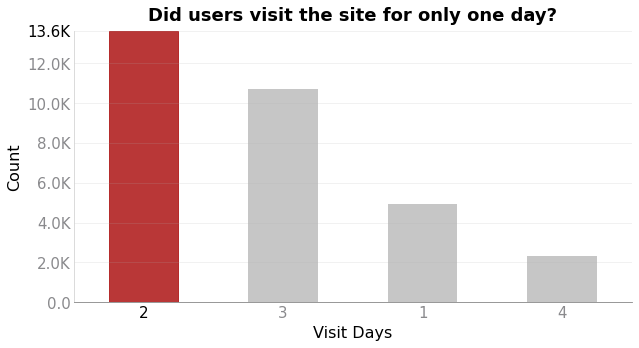

In [62]:
fig,ax= plt.subplots(figsize=(10,5))
(users.groupby(['user_id','day'])
 .count()
 .iloc[:,0]
 .sort_values()
 .value_counts()
 .plot.bar(color='silver',alpha=.9,rot=0))
modifyChart(ax, "Did users visit the site for only one day?", 13
            ,titleSize=18,xLabel='Visit Days',yLabel='Count',
            topValueColor='firebrick',maxs=ax.get_children()[0].get_height(),highlightTop=True,highlightXVal=True)
ax.set_yticklabels([f'{human_format(i,precision=1)}' for i in ax.get_yticks()])
plt.grid(axis='y',alpha=.2)

- Most users visited the site for two or three days; users on a whole did return to the site for more than one day.
- However, users didn't visit the site for more than 4 days. 

Exploring revenue by day per experiment group

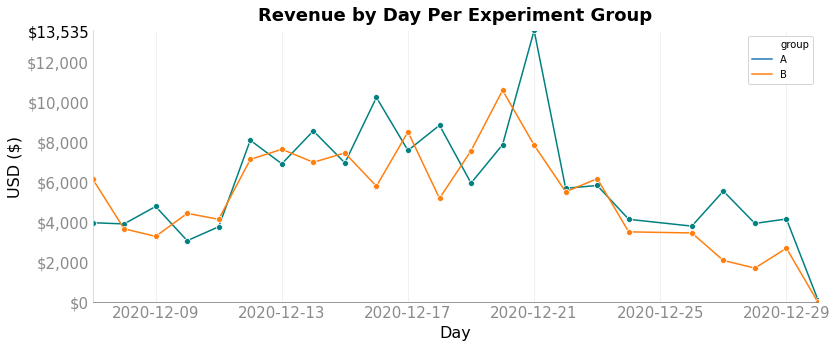

In [42]:
fig,ax=plt.subplots(figsize=(13,5))
rev = users.groupby(["group","day"]).agg({"details":'sum'}).reset_index()
plt.ylim(0, rev['details'].max())
plt.xlim(rev['day'].min(), rev['day'].max())
ax.set_xticks(ax.get_xticks())
sns.lineplot(x='day',y='details',hue='group',data=rev,markers=True,marker='o',ci=None,ax=ax)
modifyChart(ax,'Revenue by Day Per Experiment Group',
            13,xLabel='Day',yLabel='USD ($)',topValueColor='teal',
            maxs=rev['details'].max(),highlightTop='black',titleSize=18)
plt.grid(axis='x',alpha=.2)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'${i:,.0f}' for i in ax.get_yticks()])
plt.show()

As is :
- In parallel with events activity distribution chart, most revenue between Dec 12 and 23th. 
- Group A seems to be brining in more money in comparison to group B.
- Of special notice is Dec 21st for the control group where revenue for that day was \\$13,535; a possible outlier that may need to be looked into but will not be done in this task as the goal is event visit conversion rates. 

Looking at cumulative revenue.

In [67]:
users['day'].min()

datetime.date(2020, 12, 7)

In [70]:
ax.get_xticklabels()[0].set_rotation(15)

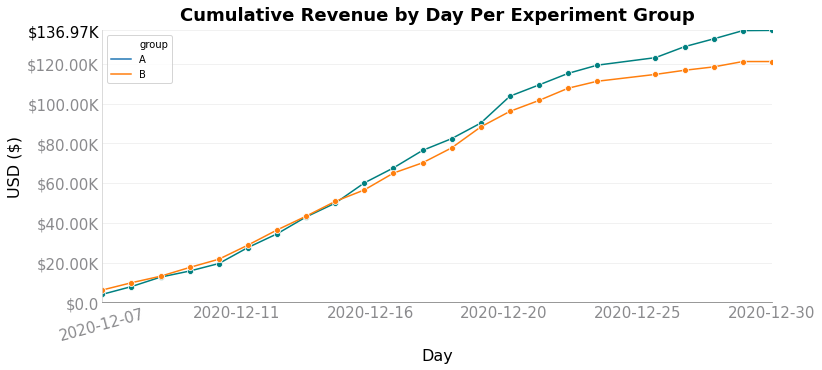

In [87]:
fig,ax=plt.subplots(figsize=(12,5))
revCum = users.groupby(["group","day"]).agg({"details":'sum'}).groupby(level=0).cumsum().reset_index()
plt.ylim(0, revCum['details'].max())

sns.lineplot(x='day',y='details',hue='group',data=revCum,markers=True,marker='o',ci=None,ax=ax)
modifyChart(ax,'Cumulative Revenue by Day Per Experiment Group',
            13,xLabel='Day',yLabel='USD ($)',topValueColor='teal',
            maxs=revCum['details'].max(),highlightTop='black',titleSize=18)
plt.grid(axis='y',alpha=.2)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'${human_format(i,precision=2)}' for i in ax.get_yticks()])

ax.set_xlim(revCum['day'].min(), revCum['day'].max())
ax.set_xticks(pd.date_range(revCum['day'].min(), revCum['day'].max(), 6))
ax.set_xticklabels([i.date() #set x tick labels as date format and in 12 intervals
    for i in pd.date_range(revCum['day'].min(), revCum['day'].max(), 6)])
ax.get_xticklabels()[0].set_rotation(15)
plt.show()

- In part due to the 21st high revenue, tentatively speaking, group A has the lead over group B in terms of revenue.
- After the 26th, group A started to bring more revenue regardless of the outlier (Dec 21st) as indicated by the distribution of points. This is definitely something that should be looked into but again will not be done in this task. 

## EDA: Funnels

Data validation for stage funnel -> Does product page come before the login page? 

In [44]:
#for each user, find the time of the first occurrence of each event.
usersFirstEvent = users.pivot_table(index='user_id',
                         columns='event_name',
                         values='event_dt',
                         aggfunc='min')

#change order to follow the defined customer journey
usersFirstEvent = usersFirstEvent[['login','product_page','product_cart','purchase']]

#check using login and product page (purchase and product cart are not checked)
usersFirstEvent[(usersFirstEvent[['login','product_page']].apply(
    lambda x: x - x.shift(+1), 1)['product_page']  < pd.Timedelta(0))]

event_name,login,product_page,product_cart,purchase
user_id,,,,


Login and product page follow a consecutive flow. 

Dividing users by their respective experimental group.

In [45]:
A = users.query("group == 'A'")
B = users.query("group == 'B'")

For the cumulative as well as groups, how does the unique relative ratio to the next stage look?

In [46]:
# total unique users per event (value count for each user)
fig = make_subplots(rows=1, cols=3,subplot_titles=("A", "B", "All"))
color = ['#80DE9F',"lightsalmon",'aquamarine']
for df, i, title,c in zip([A, B, users], range(1, 4), ['A', 'B', 'All'],color):
    relativeRatio = (df
                   .groupby('event_name')
                   .agg({"user_id": 'nunique'})
                   .sort_values('user_id', ascending=False)
                   .reset_index())
    relativeRatio.columns = ['event_name', 'uniqueUserCount']

    # share of users at current stage relative to previous stage
    relativeRatio['user_conversion'] = (relativeRatio['uniqueUserCount']
                                      .div(relativeRatio['uniqueUserCount']
                                           .shift(1))
                                      .fillna(1) * 100)

    fig.add_trace(go.Funnel(
        x=relativeRatio['user_conversion'],
        y=relativeRatio['event_name'],marker = {"color": c},
        opacity=.7), row=1, col=i,
    )
    if i != 1:
        fig.update_yaxes(showticklabels=False, col=i)

fig.update_layout(title={'text':'Unique User Relative Ratio to The Next Stage',
                         'font':dict(family="Courier New, monospace",size=25), "x":.5,"y":.93},
                 showlegend=False)

fig.show()

- A high proportion of users advance from the login to the product page with half of those users making it to the purchase page.
- Of interest, is the product cart page relative ratio where group A has 6% of unique users advance from the previous stage, purchase. 
- However, considering the funnel defined this may have been due to redirection straight to the purchase stage (group A had the highest revenue). 
    -Without any data though, we can't really conclude if this was so 

In [102]:
(Uniqueuser_event['user_id']
                   .divide(Uniqueuser_event['user_id'].max())
                   .multiply(100).apply(lambda x: f'{x:.2f}%'))

event_name
login           100.00%
product_page     65.92%
purchase         34.21%
product_cart     32.98%
Name: user_id, dtype: object

In [117]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("A", "B", "All"))
color = ['#80DE9F',"lightsalmon",'aquamarine']
for df, i, title,c in zip([A, B, users], range(1, 4), ['A', 'B', 'All'],color):
    Uniqueuser_event = (df
                    .groupby('event_name')
                    .agg({'user_id':'nunique'})
                    .sort_values('user_id',ascending=False))
    if i != 1:
        fig.update_yaxes(showticklabels=False, col=i)
    fig.add_trace(go.Funnel(
                y=Uniqueuser_event.index,
                x=(Uniqueuser_event['user_id']
                   .divide(Uniqueuser_event['user_id'].max())
                   .multiply(100).apply(lambda x: f'{x:.2f}%')),
                opacity=.7,marker = {"color": c}),row=1, col=i)

        
fig.update_layout(title={'text':'Unique User Funnel',
                         'font':dict(family="Courier New, monospace"
                          ,size=30), "x":.5,"y":.93},showlegend=False)

fig.show()

- When we take a look at the unique users event funnel, we can see that group A has a relatively larger proportion of users per event with the exception of the product cart.
- Overall though, from all the new users, roughly 1/3 of them made it to the purchase page. 


Proportion of events funnel.

In [48]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("A", "B", "All"))
color = ['#80DE9F',"lightsalmon",'aquamarine']
for df, i, title,c in zip([A, B, users], range(1, 4), ['A', 'B', 'All'],color):
    eventProportions = (df['event_name'].value_counts(normalize=True)*100).reset_index()

    fig.add_trace(go.Funnel(
                x=eventProportions['event_name'],
                y=eventProportions['index'].apply(lambda x: x),
                opacity=.7,marker = {"color": c}),row=1, col=i)
    if i != 1:
        fig.update_yaxes(showticklabels=False, col=i)
fig.update_layout(title={'text': 'Event Proportion',
                        'font': dict(family="Courier New, monospace", size=30),
                         "x":.5,"y":.93},showlegend=False)
fig.show()

- Relative to the other groups, group A has a lower share of users in the login and product cart page hinting at the hypothesis of users in that group being led more into the purchase page relative to the experimental group.
- Roughly speaking, 14-15% of events recorded were made in the critical purchase stage 

# A/B Test - Hypothesis

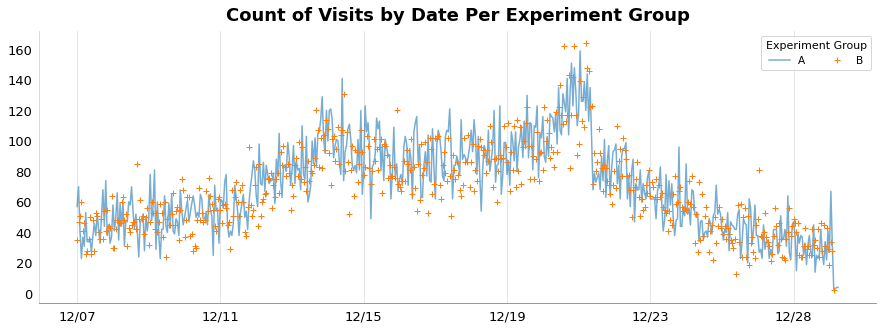

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
users.groupby(['group','day','hour']).agg({
    'user_id': 'count'
}).query("group == 'A'").reset_index(0)['user_id'].plot.line(style='-',rot=0,alpha=.6)
users.groupby(['group','day','hour']).agg({
    'user_id': 'count'
}).query("group == 'B'").reset_index(0)['user_id'].plot.line(style='+',rot=0,alpha=1)


ax.set_xticklabels(['/'.join(x.get_text().replace("(","").split(',')[0].split('-')[1:]) for 
                   x in ax.get_xticklabels()])
plt.legend(['A','B'], fontsize=10.5, ncol=3,title='Experiment Group',title_fontsize=11 ,loc='upper right')
modifyChart(ax,'Count of Visits by Date Per Experiment Group', 13, grid='x',titleSize=18)

The distribution of event log timestamps are also roughly the same over the two groups. 

## Hypothesis:
Metrics:

**Product page user conversion:** # of unique users who viewed product page/ total unique users

**Product cart user conversion:** # of unique users who viewed product cart page/ total unique users

**Unique user conversion:** # of unique users who made a purchase / total unique users


metrics = product page user conversion, product cart user conversion, unique user conversion 

**Per metric (see variable metrics)**

HO:  P(A) = P(B)

H1: P(A) != P(B)



In [50]:
users['user_id'].nunique()

9848

A two-proportion Z-test will be used to test the aforementioned hypotheses given the nature of the outcomes (binary). We will need to gather the aggregate orders and total visitors for the two groups to test the hypothesis. Note, that our samples fit the criteria of the test:
-  independent random samples: ** different recommender systems used for the groups**
-  sample size > 30 **(n= 9,848, A(n)= 4,978, B(n)= 4,870)** 
- assume normality given large sample size
The defacto false positive rate of 10% will be tolerated for this test.

To test this, we will be using the proportion_ztest methods from the statsmodel library. Here are the parameters used:

- nobs = total # of trials (unique users view)
- count = # of successful trials (total # of unique users)
- value = proportion to test against (0 assuming equality -> two-sideed)
- alternative = alternative hypothesis ('two-sided'')

In [52]:
# setting up data
alpha = .1 
comparisons = 3 #the 3 comparisons (see metrics) using same samples
bonferroni_alpha = alpha/comparisons

# splitting data by group and by relevant event
productPageA, productCartA,purchaseA = [A.query("event_name == @events")for events 
     in ['product_page', 'product_cart','purchase']]
productPageB, productCartB,purchaseB = [B.query("event_name == @events")for events 
     in ['product_page', 'product_cart','purchase']]

events =['product_page', 'product_cart','purchase']

#combining the relevant variables into a list to be used in a for loop
eventsA =[productPageA, productCartA,purchaseA]
eventsB=[productPageB, productCartB,purchaseB]
totalUniqueUsers =[A['user_id'].nunique(), B['user_id'].nunique()]

In [53]:
(users['group'].value_counts(normalize=True)['A'] - users['group'].value_counts(normalize=True)['B'])*100

1.7474088500878449

As previously mentioned, the 1.7% difference but acceptable in this case. 

Testing

In [54]:
for eventA,eventB,event in zip(eventsA, eventsB,events):
    z_score, p_value = sm.stats.proportions_ztest(
        [eventA['user_id'].nunique(), eventB['user_id'].nunique()],
        [totalUniqueUsers[0],totalUniqueUsers[1]])
    print(f'Event:{event} \tBonferroni Alpha: {bonferroni_alpha}')
    print([eventA['user_id'].nunique(), eventB['user_id'].nunique()],[totalUniqueUsers])
    if p_value < bonferroni_alpha:
        print(f'Reject null hypothesis\n\tP-value={p_value:.4f} Z-score={z_score:.4f}')
    else: 
        print(f'Failed to reject null hypothesis\n\tP-value={p_value:.4f} Z-score={z_score:.4f}')
    print(f"A proportion: {eventA.user_id.nunique() /totalUniqueUsers[0]*100:.2f}%")
    print(f'B proportion:  {eventB.user_id.nunique() /totalUniqueUsers[1]*100:.2f}%')
    print('--------------------------------------------------------------------------------------------------------')
    

Event:product_page 	Bonferroni Alpha: 0.03333333333333333
[3304, 3187] [[4978, 4870]]
Failed to reject null hypothesis
	P-value=0.3300 Z-score=0.9740
A proportion: 66.37%
B proportion:  65.44%
--------------------------------------------------------------------------------------------------------
Event:product_cart 	Bonferroni Alpha: 0.03333333333333333
[1606, 1642] [[4978, 4870]]
Failed to reject null hypothesis
	P-value=0.1247 Z-score=-1.5352
A proportion: 32.26%
B proportion:  33.72%
--------------------------------------------------------------------------------------------------------
Event:purchase 	Bonferroni Alpha: 0.03333333333333333
[1761, 1608] [[4978, 4870]]
Reject null hypothesis
	P-value=0.0137 Z-score=2.4652
A proportion: 35.38%
B proportion:  33.02%
--------------------------------------------------------------------------------------------------------


In [55]:
35.38 - 33.02

2.3599999999999994

- Unique user conversion did not statistically differ for events in the product page and product cart page. 
- For the purchase page, users in the control group converted 2.36% better than the experimental group and this difference was found to be statistically significant (p < .03).


# Conclusion

- Unique user conversion **did not** statistically differ for events in the **product page and product cart** page.
- For the **purchase page**, users in the **control group converted 2.36% better** than the experimental group and this difference was found to be statistically significant **(p < .03)**.
    - In terms of the result, this may have been that there are more users that were concentrated in the purchase stage (from funnel findings) which warrants further testing. 
- It seems likely that users in **group A were disproportionately shared direct links to the purchase page** more often than users in group B, hence the difference in # of purchase. A further follow up analysis can be done to assess effectiveness of the purchase page redirect link. 